# Import Modules and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Functions needed for Data Preprocessing
from data import ( preprocess_stock_data,
                  clean_financial_ratios,
                  merge_and_clean_data,
                  filter_useful_features,
                  calculate_technical_indicators,
                  normalize_data)

# Import helper functions to run LSTM Training and Predictions
from helper import (create_df_per_stock,
                    run_for_stocks,
                    get_best_configuration,
                    final_df_cleaning,
                    create_return_arrays,
                    create_returns_for_cov, 
                    calculate_covariance_matrix,
                    plot_prediction_actual,
                    plot_mse,
                    calculate_permutation_importance,
                    plot_feature_importance,
                    prepare_data_for_feature_importance)

# Import functions for Mean Variance Optimization
from optimizer import (create_date_index,
                      pad_cov_matrices,
                      portfolioPerformance,
                      negativeSR,
                      maxSR,
                      minimizeVariance,
                      generate_dynamic_weights,
                      backtest,
                      backtest_sp500,
                      calculate_cumulative_returns,
                      calculate_volatility,
                      calculate_sharpe_ratio,
                      calculate_max_drawdown,
                      performance_metrics,
                      generate_dynamic_weights_with_start_date,
                      backtest_with_start_date)

# Load Dataset

In [2]:
# Load Data
stock = pd.read_csv('../data/stocks_1.csv')
stock_factor = pd.read_csv('../data/ratios_2.csv')
macro = pd.read_csv('../data/bond_and_cpi.csv')
sp500 = pd.read_csv('../data/sp500.csv', parse_dates=['Date_prev'])

In [3]:
# Select stocks
stock_avg = preprocess_stock_data(stock)
# Clean financial ratios data
stock_factor_1 = clean_financial_ratios(stock_avg, stock_factor)
# Merge trading data and financial ratios data and select proper companies
stock_all_final = merge_and_clean_data(stock_avg, stock_factor_1)
# Select features that are meaningful and useful
stock_final = filter_useful_features(stock_all_final)
# Calculate momentum technical indicators
stock_final_1 = stock_final.groupby('gvkey').apply(calculate_technical_indicators).reset_index(drop=True)
stock_use = stock_final_1.dropna()
stock_use.drop(columns=['yymm'], inplace=True)
# Normalization
stock_n = normalize_data(stock_use)
# Save to CSV
stock_n.to_csv('../data/normalized_data.csv', index=False)

/var/folders/z8/18vf272n36z6tx1xm5tv3qvw0000gn/T/ipykernel_72552/1027556271.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_use.drop(columns=['yymm'], inplace=True)


In [4]:
# Save unnormalized returns
unnormalized_returns = stock_use[["datadate", "tic", "trt1m"]] 
unnormalized_returns

,datadate,tic,trt1m
14,2011-03-31,AVY,0.051102
15,2011-04-30,AVY,-0.005243
16,2011-05-31,AVY,0.020364
17,2011-06-30,AVY,-0.087624
18,2011-07-31,AVY,-0.183277
...,...,...,...
7051,2023-08-31,CBRE,0.020886
7052,2023-09-30,CBRE,-0.131570
7053,2023-10-31,CBRE,-0.061197
7054,2023-11-30,CBRE,0.138737


In [5]:
data = pd.read_csv("../data/normalized_data.csv") # Load Dataset from File generated previously. 
data = final_df_cleaning(data) # Drop unnecessary columns and arrange data by ticker and dates
tickers = data['tic'].unique() # Create a List of the Unique Stock Tickers
data.head()

,index,datadate,tic,cshtrm,prccm,prchm,prclm,trt1m,CAPEI,evm,...,high_low_ratio,RSI_14,MA_3,price_to_MA_3,return_momentum_6m,MA_6,return_momentum_9m,MA_9,return_momentum_12m,MA_12
0,3388,2011-03-31,AMZN,0.057669,0.050441,0.047726,0.048270,0.449252,0.657229,0.104348,...,0.020950,0.687142,0.050675,0.673276,0.278596,0.050655,0.346955,0.046881,0.203680,151.274167
1,3389,2011-04-30,AMZN,0.055855,0.054863,0.052030,0.052741,0.479247,0.657454,0.104348,...,0.020388,0.751851,0.053232,0.698572,0.291211,0.052154,0.350194,0.049443,0.222852,156.166667
2,3390,2011-05-31,AMZN,0.051408,0.055111,0.054307,0.057432,0.427200,0.657571,0.104227,...,0.010842,0.721283,0.055518,0.671418,0.270170,0.053198,0.327768,0.051806,0.249207,162.102500
3,3391,2011-06-30,AMZN,0.046094,0.057310,0.054270,0.054622,0.449368,0.657700,0.104227,...,0.022005,0.734112,0.057899,0.669438,0.275018,0.054399,0.255807,0.053366,0.306600,170.038333
4,3392,2011-07-31,AMZN,0.044648,0.062395,0.059825,0.061283,0.479955,0.657969,0.104227,...,0.017924,0.825139,0.060509,0.699107,0.333047,0.056992,0.267572,0.055250,0.309609,178.757500


In [6]:
tickers

array(['AMZN', 'AVY', 'AXON', 'BBWI', 'BKNG', 'BLDR', 'CBRE', 'CDNS',
       'CE', 'CF', 'CHD', 'CMCSA', 'CMS', 'CNC', 'COST', 'DECK', 'DLTR',
       'EA', 'EQIX', 'FI', 'FICO', 'GOOGL', 'INCY', 'LULU', 'MA', 'MOH',
       'NDAQ', 'NI', 'NVDA', 'ODFL', 'OKE', 'PKG', 'SBAC', 'STLD', 'TDG',
       'TGT', 'TYL', 'UNH', 'URI', 'V', 'VLO', 'WST'], dtype=object)

In [7]:
# Dictionary to hold dataframe for each stock
df_per_stock = create_df_per_stock(tickers=tickers, dataframe=data)

/Users/talhajamal/Desktop/CodingProjects/LSTM_based_Portfolio_Optimization/src/helper.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trt1m'] = df['trt1m'].shift(-1) # Shift Target Return up


# Hyperparameter Tuning for LSTMs and Return Predictions

In [8]:
# Test with small list
param_grid = {
    'lstm_units': [100, 150],
    'dense_units1': [50, 100, 150],
    'dense_units2': [50, 75],
    'batch_size': [32, 64],
    'optimizer': ['adam']
}

In [9]:
# Only Run the below command when running a new model - otherwise use the saved data within the 
# past_results folder

#models = run_for_stocks(tickers, df_per_stock, param_grid)

In [10]:
# Get Best Configuration for each stock via the CSV files
# Only run when you've finished running a new model above to confirm all best_configurations are saved
# Otherwise use best_configs inside the past_results folder
"""
best_configurations = get_best_configuration(tickers=tickers)
best_configurations_df = pd.DataFrame(best_configurations).T.reset_index()
best_configurations_df.columns = ['ticker',
                                  'lstm_units',
                                  'dense_units1',
                                  'dense_units2',
                                  'batch_size',
                                  'optimizer', 
                                  'avg_val_mse']
best_configurations_df
best_configurations_df.to_csv("../results/best_configs.csv")
"""

'\nbest_configurations = get_best_configuration(tickers=tickers)\nbest_configurations_df = pd.DataFrame(best_configurations).T.reset_index()\nbest_configurations_df.columns = [\'ticker\',\n                                  \'lstm_units\',\n                                  \'dense_units1\',\n                                  \'dense_units2\',\n                                  \'batch_size\',\n                                  \'optimizer\', \n                                  \'avg_val_mse\']\nbest_configurations_df\nbest_configurations_df.to_csv("../results/best_configs.csv")\n'

In [11]:
# Create a Numpy Array of Returns
without_macro_features = "../past_results/without_macro_data/"

default_lstm_no_burning_window_12m = create_return_arrays(tickers=tickers,
                                                          folder=f"{without_macro_features}default_lstm_no_burning_window_12m")
default_lstm_with_burning_window_12m = create_return_arrays(tickers=tickers,
                                                            folder=f"{without_macro_features}default_lstm_burning_window_12m")
default_lstm_no_burning_window_3m = create_return_arrays(tickers=tickers,
                                                         folder=f"{without_macro_features}default_lstm_no_burning_window_3m")
default_lstm_with_burning_window_3m = create_return_arrays(tickers=tickers,
                                                            folder=f"{without_macro_features}default_lstm_with_burning_window_3m")
default_lstm_with_burning_window_6m = create_return_arrays(tickers=tickers,
                                                           folder=f"{without_macro_features}default_lstm_burning_window_6m")

# Covariance Matrix via Shrinkage

In [12]:
# Each List below stores Matrix of Returns with Past Returns + Next Month's Return Predictions for each Month

returns_data_12m_no_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_no_burning_window_12m)

returns_data_12m_with_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_with_burning_window_12m)

returns_data_3m_no_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_no_burning_window_3m)

returns_data_3m_with_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_with_burning_window_3m)

returns_data_6m_with_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_with_burning_window_6m)

In [13]:
# Each List  below stores a 42 x 42 Covariance Matrix for each out of sample period for the relevant sequence size for each Month

cov_matrices_12m_no_burning_window, shrinkages_12m_no_burning_window = calculate_covariance_matrix(returns_data_12m_no_burning_window)

cov_matrices_12m_with_burning_window, shrinkages_12m_with_burning_window = calculate_covariance_matrix(returns_data_12m_with_burning_window)

cov_matrices_3m_no_burning_window, shrinkages_3m_no_burning_window = calculate_covariance_matrix(returns_data_3m_no_burning_window)

cov_matrices_3m_with_burning_window, shrinkages_3m_with_burning_window = calculate_covariance_matrix(returns_data_3m_with_burning_window)

cov_matrices_6m_with_burning_window, shrinkages_6m_with_burning_window = calculate_covariance_matrix(returns_data_6m_with_burning_window)

In [14]:
print(f"The Shape of 12M No Burning Window Returns: {default_lstm_no_burning_window_12m.shape}")
print(f"The Length of the list of Cov Matrix for 12M No Burning Window Returns: {len(cov_matrices_12m_no_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 12M With Burning Window Returns: {default_lstm_with_burning_window_12m.shape}")
print(f"The Length of the list of Cov Matrix for 12M with Burning Window Returns: {len(cov_matrices_12m_with_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 3M No Burning Window Returns: {default_lstm_no_burning_window_3m.shape}")
print(f"The Length of the list of Cov Matrix for 3M No Burning Window Returns: {len(cov_matrices_3m_no_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 3M With Burning Window Returns: {default_lstm_with_burning_window_3m.shape}")
print(f"The Length of the list of Cov Matrix for 3M with Burning Window Returns: {len(cov_matrices_3m_with_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 6M With Burning Window Returns: {default_lstm_with_burning_window_6m.shape}")
print(f"The Length of the list of Cov Matrix for 6M with Burning Window Returns: {len(cov_matrices_6m_with_burning_window)}")


The Shape of 12M No Burning Window Returns: (29, 42)
The Length of the list of Cov Matrix for 12M No Burning Window Returns: 29
----------------------------------------------------------------------------------
The Shape of 12M With Burning Window Returns: (19, 42)
The Length of the list of Cov Matrix for 12M with Burning Window Returns: 19
----------------------------------------------------------------------------------
The Shape of 3M No Burning Window Returns: (30, 42)
The Length of the list of Cov Matrix for 3M No Burning Window Returns: 30
----------------------------------------------------------------------------------
The Shape of 3M With Burning Window Returns: (28, 42)
The Length of the list of Cov Matrix for 3M with Burning Window Returns: 28
----------------------------------------------------------------------------------
The Shape of 6M With Burning Window Returns: (25, 42)
The Length of the list of Cov Matrix for 6M with Burning Window Returns: 25


# Plots for Slides

AMZN's Predicted and Actual Results


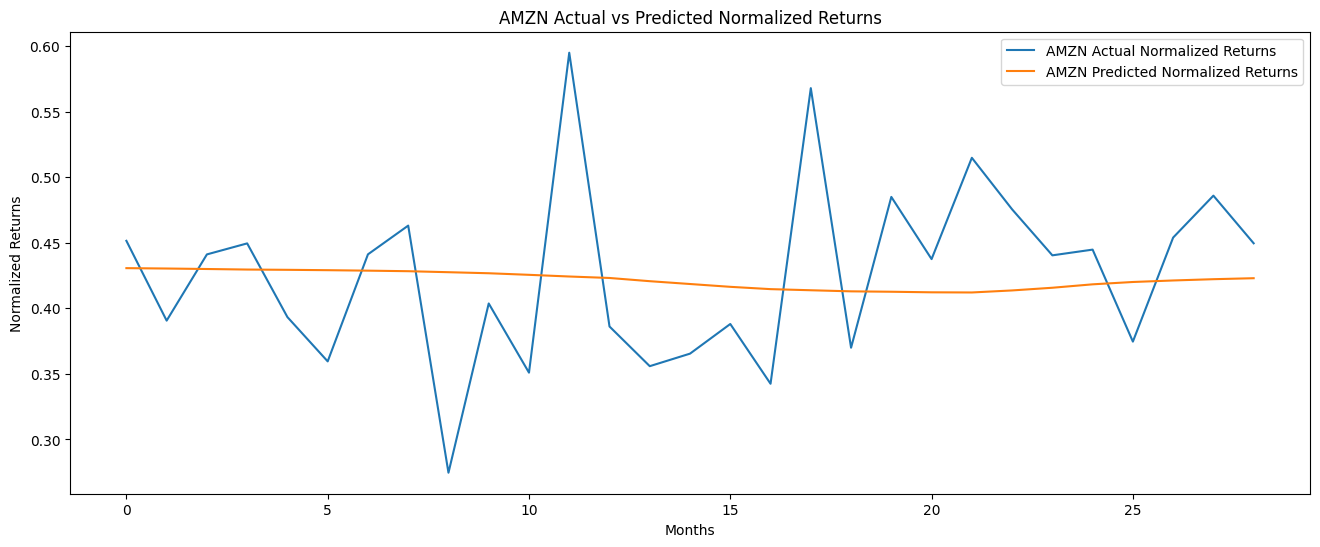

In [15]:
plot_prediction_actual(ticker='AMZN', figsize=(16,6))

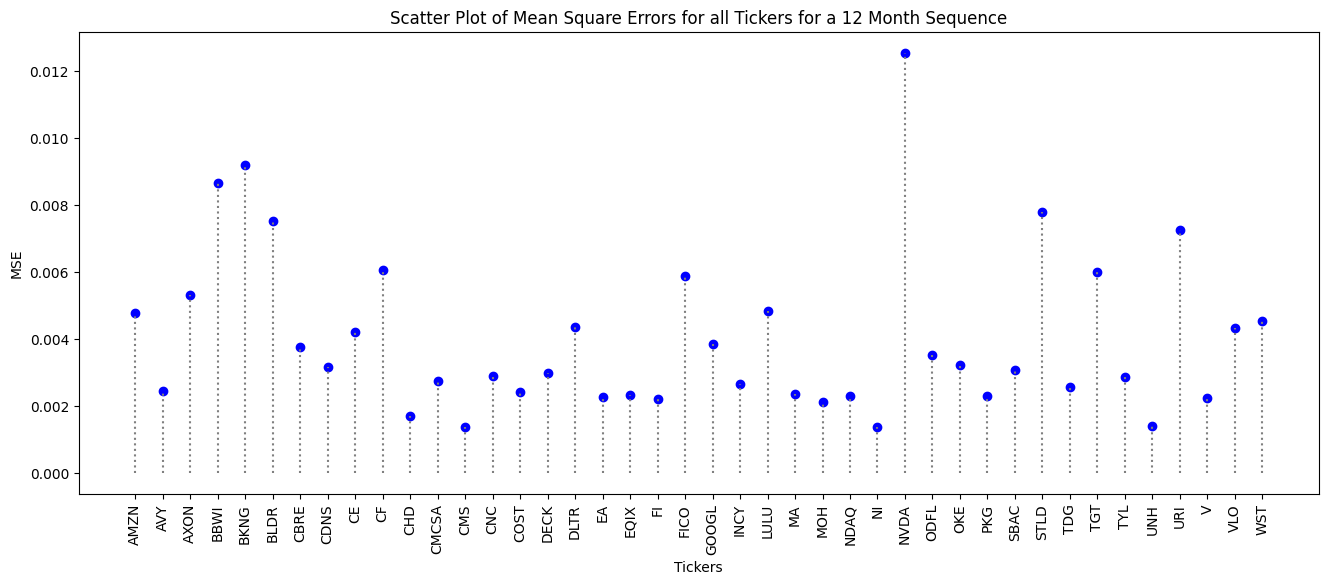

In [16]:
plot_mse(tickers=tickers)

In [17]:
# Run Model only for AMZN
amzn_model = run_for_stocks(stock_list=['AMZN'], df_per_stock=df_per_stock, param_grid=param_grid)

Processing stock: AMZN
Hyperparameter Tuning Results already exist for AMZN. Loading existing results.
Training and evaluating the best model for AMZN.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1435 - mse: 0.1435
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mse: 0.0063 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mse: 0.0037
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - mse: 0.0044
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mse: 0.0036
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mse: 0.0027
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mse: 0.0030
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mse: 0.0030
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mse: 0.0032
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mse: 0.0030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
For Stock AMZN the MSE is 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━

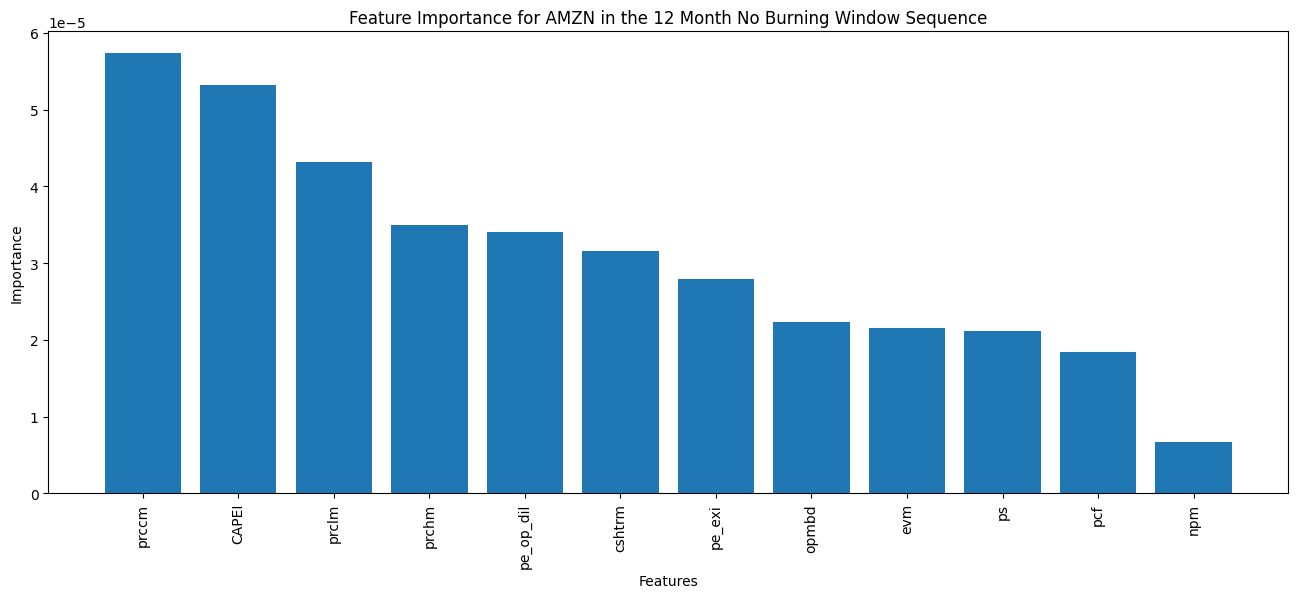

In [28]:
amzn_X, amzn_y, feature_names = prepare_data_for_feature_importance(df_per_stock['AMZN'].drop(columns=['index']))
feature_importance = calculate_permutation_importance(amzn_model['AMZN'], amzn_X, amzn_y)
plot_feature_importance(feature_importance, feature_names)

# Mean Variance Portfolio Optimization

### Data preprocessing

In [ ]:
# Combine all predicted return results

# load return matrices
df_list = [
    pd.DataFrame(default_lstm_no_burning_window_12m),
    pd.DataFrame(default_lstm_with_burning_window_12m),
    pd.DataFrame(default_lstm_no_burning_window_3m),
    pd.DataFrame(default_lstm_with_burning_window_3m),
    pd.DataFrame(default_lstm_with_burning_window_6m)
]

# Add time index for each dataframe in the list
for i, df in enumerate(df_list):
    df.columns = tickers
    df_list[i] = create_date_index(df)

# Initialize an empty dataframe for combined results
combined_df = pd.DataFrame()

# Define column suffixes
column_suffixes = [
    'pred_no_burning_window_12m',
    'pred_with_burning_window_12m',
    'pred_no_burning_window_3m',
    'pred_with_burning_window_3m',
    'pred_with_burning_window_6m'
]

# Combine dataframes into panel format
for df, suffix in zip(df_list, column_suffixes):
    df_melted = df.reset_index().melt(id_vars=['index'], value_vars=tickers, var_name='ticker', value_name=suffix)
    df_melted.rename(columns={'index': 'date'}, inplace=True)
    if combined_df.empty:
        combined_df = df_melted
    else:
        combined_df = pd.merge(combined_df, df_melted, on=['date', 'ticker'], how='outer')

# Sort the combined dataframe and reset the index
combined_df = combined_df.sort_values(by=['ticker', 'date']).reset_index(drop=True)


In [ ]:
# Combine with normalized return data
data['datadate'] = pd.to_datetime(data['datadate'])
combined_df = pd.merge(combined_df, data[['datadate', 'tic', 'trt1m']], left_on=['date', 'ticker'], right_on=['datadate', 'tic'], how='left')
combined_df.drop(columns=['datadate', 'tic'], inplace=True)

# Combine risk free rates with combine_df
macro['caldt'] = pd.to_datetime(macro['caldt'])
macro['year_month'] = macro['caldt'].dt.to_period('M')
combined_df['year_month'] = combined_df['date'].dt.to_period('M')
combined_df = pd.merge(combined_df, macro[['year_month', 't30ret']], on='year_month', how='left')
combined_df.drop(columns=['year_month'], inplace=True)

# Rename columns
combined_df.rename(columns={'trt1m': 'RET','t30ret':'rf'}, inplace=True)

# Combine actual unnormalized return data
unnormalized_returns['datadate'] = pd.to_datetime(unnormalized_returns['datadate'])
combined_df = pd.merge(combined_df, unnormalized_returns[['datadate', 'tic', 'trt1m']], left_on=['date', 'ticker'], right_on=['datadate', 'tic'], how='left')
combined_df.drop(columns=['datadate', 'tic'], inplace=True)

# Rename columns
combined_df.rename(columns={'trt1m': 'actual_RET'}, inplace=True)

combined_df

In [ ]:
# Create separate dataframes for future use
returns = combined_df.pivot(index='date', columns='ticker', values='RET')
risk_free_rate = combined_df.pivot(index='date', columns='ticker', values='rf')
actual_returns = combined_df.pivot(index='date', columns='ticker', values='actual_RET')

pred_no_burning_window_12m = combined_df.pivot(index='date', columns='ticker', values='pred_no_burning_window_12m')
pred_with_burning_window_12m = combined_df.pivot(index='date', columns='ticker', values='pred_with_burning_window_12m')
pred_no_burning_window_3m = combined_df.pivot(index='date', columns='ticker', values='pred_no_burning_window_3m')
pred_with_burning_window_3m = combined_df.pivot(index='date', columns='ticker', values='pred_with_burning_window_3m')
pred_with_burning_window_6m = combined_df.pivot(index='date', columns='ticker', values='pred_with_burning_window_6m')

In [ ]:
# Pad the covariance matrices list to a specified length for future use (add zero-matrices at front)
cov_matrices_12m_no_burning_window = pad_cov_matrices(cov_matrices_12m_no_burning_window, target_length=30)
cov_matrices_12m_with_burning_window = pad_cov_matrices(cov_matrices_12m_with_burning_window, target_length=30)
cov_matrices_3m_no_burning_window = pad_cov_matrices(cov_matrices_3m_no_burning_window, target_length=30)
cov_matrices_3m_with_burning_window = pad_cov_matrices(cov_matrices_3m_with_burning_window, target_length=30)
cov_matrices_6m_with_burning_window = pad_cov_matrices(cov_matrices_6m_with_burning_window, target_length=30)


### Generate weights

In [ ]:
models_dict = {
    'nb12m': (pred_no_burning_window_12m, cov_matrices_12m_no_burning_window),
    'wb12m': (pred_with_burning_window_12m, cov_matrices_12m_with_burning_window),
    'nb3m': (pred_no_burning_window_3m, cov_matrices_3m_no_burning_window),
    'wb3m': (pred_with_burning_window_3m, cov_matrices_3m_with_burning_window),
    'wb6m': (pred_with_burning_window_6m, cov_matrices_6m_with_burning_window)
}

weights_dict = {}

# Generate weights for each model prediction using MaxSR method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='pred_max_sr', risk_free_rate=risk_free_rate)
    weights_dict[f'{model_name}_maxSR'] = weights
    print(f'Weights for "{model_name}_maxSR" model generated.')

# Generate weights for each model prediction using minVar method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='pred_min_var', risk_free_rate=risk_free_rate)
    weights_dict[f'{model_name}_minVar'] = weights
    print(f'Weights for "{model_name}_minVar" model generated.')
    
print(f'Weights generations done.')

In [ ]:
# Generate benchmark portfolio

# max_sr portfolio based on historical data
max_sr_weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='max_sr', risk_free_rate=risk_free_rate)
weights_dict["maxSR"] = max_sr_weights

# min var portfolio based on historical data
min_var_weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='min_var', risk_free_rate=risk_free_rate)
weights_dict["minVar"] = min_var_weights

# Equally weighted portfolio
equal_weights = pd.DataFrame(1/len(tickers), index=returns.index, columns=tickers)
weights_dict["equal"] = equal_weights

weights_dict.keys()

In [ ]:
# Check the generated weights
weights_dict["nb3m_maxSR"].head(10)

In [ ]:
# Check the generated weights
weights_dict["nb3m_maxSR"].tail(10)

# Backtesting Results

In [ ]:
# Backtest portfolios
initial_capital = 1000
portfolios = weights_dict

# Perform backtest
results = {}
for name, weights in portfolios.items():
    results[name] = backtest(weights, actual_returns, initial_capital)

# Add SP500 portfolio
results['SP500'] = backtest_sp500(sp500, start_date = '2021-07-31',initial_capital=initial_capital )
    
# Plot results
plt.figure(figsize=(12, 8))
for name, values in results.items():
    plt.plot(returns.index, values, label=name)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### Performance Matrices

In [ ]:
# Calculate metrics for each portfolio
metrics = []
for name, values in results.items():
    cumulative_returns = calculate_cumulative_returns(values)
    volatility = calculate_volatility(values)
    sharpe_ratio = calculate_sharpe_ratio(values, risk_free_rate = risk_free_rate)
    max_drawdown = calculate_max_drawdown(values)
    metrics.append({
        'Portfolio': name,
        'Cumulative Returns': cumulative_returns,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics)
metrics_df

### Re-backtest starting on the same date
We notice that different portfolios start at different dates, which might influence the results. It seems that the starting date actually matters. So let's start backtesting on the same date.

In [ ]:
# Define models and weights dictionary
models_dict = {
    'nb12m': (pred_no_burning_window_12m, cov_matrices_12m_no_burning_window),
    'wb12m': (pred_with_burning_window_12m, cov_matrices_12m_with_burning_window),
    'nb3m': (pred_no_burning_window_3m, cov_matrices_3m_no_burning_window),
    'wb3m': (pred_with_burning_window_3m, cov_matrices_3m_with_burning_window),
    'wb6m': (pred_with_burning_window_6m, cov_matrices_6m_with_burning_window)
}

weights_dict = {}
start_date = '2022-06-30'

# Generate weights for each model prediction using MaxSR method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights_with_start_date(returns, pred_returns, cov_matrices, method='pred_max_sr', risk_free_rate=risk_free_rate, start_date=start_date)
    weights_dict[f'{model_name}_maxSR'] = weights
    print(f'Weights for "{model_name}_maxSR" model generated.')

# Generate weights for each model prediction using minVar method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights_with_start_date(returns, pred_returns, cov_matrices, method='pred_min_var', risk_free_rate=risk_free_rate, start_date=start_date)
    weights_dict[f'{model_name}_minVar'] = weights
    print(f'Weights for "{model_name}_minVar" model generated.')

print(f'Weights generations done.')


In [ ]:
# Generate benchmark portfolio

# max_sr portfolio
max_sr_weights = generate_dynamic_weights_with_start_date(returns, pred_returns, cov_matrices, method='max_sr', risk_free_rate=risk_free_rate, start_date=start_date)
weights_dict["maxSR"] = max_sr_weights

# min var portfolio
min_var_weights = generate_dynamic_weights_with_start_date(returns, pred_returns, cov_matrices, method='min_var', risk_free_rate=risk_free_rate, start_date=start_date)
weights_dict["minVar"] = min_var_weights

# Equally weighted portfolio
equal_weights = pd.DataFrame(1/len(tickers), index=returns.index, columns=tickers)
weights_dict["equal"] = equal_weights

weights_dict.keys()

In [ ]:
# Perform backtest with same start date
results = {}
for name, weights in weights_dict.items():
    results[name] = backtest_with_start_date(weights, actual_returns, initial_capital, start_date)

# Add SP500 portfolio
results['SP500'] = backtest_sp500(sp500, start_date = start_date, initial_capital=initial_capital)
    
# Plot results
plt.figure(figsize=(12, 8))
for name, values in results.items():
    plt.plot(returns.loc[start_date:].index, values, label=name)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [ ]:
# Calculate metrics for each portfolio
metrics = []
for name, values in results.items():
    cumulative_returns = calculate_cumulative_returns(values)
    volatility = calculate_volatility(values)
    sharpe_ratio = calculate_sharpe_ratio(values, risk_free_rate = risk_free_rate)
    max_drawdown = calculate_max_drawdown(values)
    metrics.append({
        'Portfolio': name,
        'Cumulative Returns': cumulative_returns,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics)
metrics_df

# Use below Data for Presentation Slides

In [ ]:
# Lets first try to get the model to run for 1 stock
amzn = data[data['tic'] == 'AMZN'].iloc[:, :]
y = amzn['trt1m'].values
amzn.drop(columns=['trt1m'], inplace=True)
X = amzn.iloc[:, 2:].values
print(f"The Shape of X Features is: {X.shape}")
print(f"The Shape of y Features is: {y.shape}")

In [ ]:
sequence_length = 12 # Feed past 12 month returns into sequence for LSTM
# Converting Features into 3D space for LSTM to add a time component
X_features, y_target = [], []
for i in range(X.shape[0] - sequence_length):
    X_features.append(X[i:i+sequence_length])
    y_target.append(y[i + sequence_length])
X_features = np.array(X_features)
y_target = np.array(y_target)

print(f"The Shape of X Features is: {X_features.shape}")
print(f"The Shape of y Features is: {y_target.shape}")

In [ ]:
train_size = int(len(amzn) * 0.8)
print(f"The size of my training set will be : {train_size} and the test set will be : {int(len(amzn)) - train_size}")
X_train, y_train = X_features[:train_size], y_target[:train_size]
y_train.reshape(-1, 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
X_test, y_test = X_features[train_size:], y_target[train_size:]
y_target.reshape(-1, 1)
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

### Performance matrices and plots for presentation

##### Cumulative Return and Drawdown performance (matrices and plots) for nb12m_maxSR, wb12m_maxSR, nb12m_minVar, and wb12m_minVar

In [ ]:
# Portfolios to compare the burning window effects
selected_portfolios = ['nb12m_maxSR',  'nb12m_minVar', 'wb12m_maxSR','wb12m_minVar']
selected_metrics_df = performance_metrics(results, selected_portfolios, risk_free_rate)
selected_metrics_df

In [ ]:
# Plot Cumulative Returns
plt.figure(figsize=(12, 8))
for name in selected_portfolios:
    aligned_index = returns.index[-len(results[name]):]  # Align the index to match results length
    plt.plot(aligned_index, results[name], label=name)
plt.title('Cumulative Return Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Plot Drawdown
plt.figure(figsize=(12, 8))
for name in selected_portfolios:
    portfolio_values = results[name]
    peak = portfolio_values[0]
    drawdown = [0]
    for value in portfolio_values[1:]:
        if value > peak:
            peak = value
        drawdown.append((peak - value) / peak)
    aligned_index = returns.index[-len(drawdown):]  # Align the index to match drawdown length
    plt.plot(aligned_index, drawdown, label=name)
plt.title('Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

##### Cumulative Return and Drawdown performance for all models except benchmark portfolios

In [ ]:
# Performance metrics for all models except benchmark portfolios
all_models_except_benchmark = [
    'nb12m_maxSR', 'wb12m_maxSR', 'nb3m_maxSR', 'wb3m_maxSR', 'wb6m_maxSR', 
    'nb12m_minVar', 'wb12m_minVar', 'nb3m_minVar', 'wb3m_minVar', 'wb6m_minVar'
]
all_metrics_except_benchmark = performance_metrics(results, all_models_except_benchmark, risk_free_rate)
all_metrics_except_benchmark

In [ ]:
# Plot Cumulative Returns
plt.figure(figsize=(12, 8))
for name in all_models_except_benchmark:
    aligned_index = returns.index[-len(results[name]):]  # Align the index to match results length
    plt.plot(aligned_index, results[name], label=name)
plt.title('Cumulative Return Comparison (all models)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Plot Drawdown
plt.figure(figsize=(12, 8))
for name in all_models_except_benchmark:
    portfolio_values = results[name]
    peak = portfolio_values[0]
    drawdown = [0]
    for value in portfolio_values[1:]:
        if value > peak:
            peak = value
        drawdown.append((peak - value) / peak)
    aligned_index = returns.index[-len(drawdown):]  # Align the index to match drawdown length
    plt.plot(aligned_index, drawdown, label=name)
plt.title('Drawdown Comparison (all models)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()


##### Cumulative Return and Drawdown performance for all models, including benchmark portfolio

In [ ]:
# All portfolios including benchmark portfolios
all_portfolios = [
    'nb12m_maxSR', 'wb12m_maxSR', 'nb3m_maxSR', 'wb3m_maxSR', 'wb6m_maxSR', 
    'nb12m_minVar', 'wb12m_minVar', 'nb3m_minVar', 'wb3m_minVar', 'wb6m_minVar', 
    'maxSR', 'minVar', 'equal','SP500'
]
all_metrics_df = performance_metrics(results, all_portfolios, risk_free_rate)
all_metrics_df

In [ ]:
# Plot Cumulative Returns
plt.figure(figsize=(12, 8))
for name in all_portfolios:
    aligned_index = returns.index[-len(results[name]):]  # Align the index to match results length
    plt.plot(aligned_index, results[name], label=name)
plt.title('Cumulative Return Comparison (Including Benchmark)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Plot Drawdown
plt.figure(figsize=(12, 8))
for name in all_portfolios:
    portfolio_values = results[name]
    peak = portfolio_values[0]
    drawdown = [0]
    for value in portfolio_values[1:]:
        if value > peak:
            peak = value
        drawdown.append((peak - value) / peak)
    aligned_index = returns.index[-len(drawdown):]  # Align the index to match drawdown length
    plt.plot(aligned_index, drawdown, label=name)
plt.title('Drawdown Comparison (Including Benchmark)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()